### Country Leave One Out

Here we are doing a `leave-one-out` analysis on country. I have copied much from elsewhere, as I anticipate expanding this to other fields once I have it working, and so we ca use the same data frames, etc.

In [1]:
# some of these are not needed!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np


import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons
from PhiSpyAnalysis import read_logo

from scipy.stats import pearsonr, f_oneway, mode
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import decomposition, metrics
from sklearn.ensemble import RandomForestClassifier


import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA

from PhiSpyAnalysis import theils_u, DateConverter


import subprocess
import gzip


In [2]:
phagesdf=read_phages()

Please note that this was run with git commit 86420e1 that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages,but after filtering we kept 1,293,084 prophages from 176,702 genomes

In [3]:
metadf = read_metadata()

## Read some categories

In [4]:
catdf = read_categories()

In [5]:
acccol = 'assembly_accession'
interesting_cols = [acccol, 'isolation_country', 'isolation_date']

tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta

,assembly_accession,isolation_country,isolation_date,Category,Biome,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,NaN,NaN,NaN,NaN,ASM313v1,2396359.0,114.0,10.0,16.0,2.0,1.0,13.0,48916.0
1,GCA_000271545.1,United States,2010.295003,other water,Aquatic,Pelosinus.strA11_v1.0,5063494.0,134.0,38.0,33.0,6.0,6.0,21.0,218936.0
2,GCA_000271945.1,NaN,NaN,NaN,NaN,PgingivalisW50v1.0,2242062.0,104.0,88.0,19.0,0.0,2.0,17.0,0.0
3,GCA_000272065.2,NaN,NaN,NaN,NaN,ASM27206v2,4820065.0,595.0,263.0,79.0,1.0,49.0,29.0,15425.0
4,GCA_000272085.2,NaN,NaN,NaN,NaN,ASM27208v2,5056409.0,296.0,161.0,69.0,3.0,36.0,30.0,48106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176697,GCA_904848645.1,Brazil,NaN,NaN,NaN,LMG_24235,9749118.0,161.0,84.0,48.0,5.0,25.0,18.0,167790.0
176698,GCA_905176665.1,NaN,2014.371663,NaN,NaN,D4_OalgB6SA,5465468.0,286.0,71.0,10.0,0.0,10.0,0.0,0.0
176699,GCA_905176675.1,NaN,2014.371663,NaN,NaN,G3_OalgB6SA,4272394.0,1048.0,179.0,11.0,0.0,9.0,2.0,0.0
176700,GCA_905176695.1,NaN,2014.371663,NaN,NaN,G1_OalgB6SA,3819172.0,8736.0,68.0,2.0,0.0,2.0,0.0,0.0


## Encode the data

In [6]:
# for the country LOO we only need one field and that should make the RF quicker!

pmenc = pd.DataFrame()
for c in ['isolation_country', 'Category']:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc

,isolation_country,Category,isolation_date
0,-1,-1,-1.000000
1,166,34,2010.295003
2,-1,-1,-1.000000
3,-1,-1,-1.000000
4,-1,-1,-1.000000
...,...,...,...
176697,22,-1,-1.000000
176698,-1,-1,2014.371663
176699,-1,-1,2014.371663
176700,-1,-1,2014.371663


In [7]:
x_train, x_test, y_train, y_test = train_test_split(pmenc['isolation_country'], phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=10, bootstrap=True, n_jobs=-1, oob_score=True)
clf.fit(x_train.ravel().reshape(-1, 1), y_train)
y_pred = clf.predict(x_test.ravel().reshape(-1, 1))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print(f"f1\t{f1base}")

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


Accuracy: 0.11218761318362912
f1	0.05362046919839907


# LOGO Analysis

**NOTE**: This is run on the clusters, because it will take a while on your PC (like a day). So skip this step and read the results (see below)

I ran the code `LOGO.slurm` on the cluster, which really just runs `CountryLOGO.py`.

In [8]:
if False:
    logo = LeaveOneGroupOut()
    print("Leaving Out\tf1 delta")

    for trainidx, testidx in logo.split(x_train, y_train, groups=x_train):
        clf.fit(x_train.iloc[trainidx].ravel().reshape(-1, 1), y_train[trainidx])
        new_pred = clf.predict(x_test.ravel().reshape(-1, 1))
        f1measure = metrics.f1_score(y_test, new_pred, average='weighted')
        print(f"{pd.unique(x_train.iloc[testidx].values)}\t{f1base - f1measure}")


Read the already processed data!

In [9]:
logo = read_logo()

Groupby functions

- count() – Number of non-null observations
- sum() – Sum of values
- mean() – Mean of values
- median() – Arithmetic median of values
- min() – Minimum
- max() – Maximum
- mode() – Mode
- std() – Standard deviation
- var() – Variance

<div style="background-color: coral">
<h1>ERROR:</h1>
There is probably a problem below because we delete the NaN country column but include it in the sum, mean, median, etc
</div>

In [10]:
ic = pd.DataFrame(pd.unique(phagemeta['isolation_country'])).set_index(0)


ic['mean_phages'] = phagemeta.groupby('isolation_country').mean()['Kept']
ic['median_phages'] = phagemeta.groupby('isolation_country').median()['Kept']
ic['sum_phages'] = phagemeta.groupby('isolation_country').sum()['Kept']
ic['std_phages'] = phagemeta.groupby('isolation_country').std()['Kept']
ic['count_phages'] = phagemeta.groupby('isolation_country').count()['Kept']

ic['min_phages'] = phagemeta.groupby('isolation_country').agg(['min'])['Kept']
ic['max_phages'] = phagemeta.groupby('isolation_country').agg(['max'])['Kept']

ic['mode_phages'] = phagemeta.groupby('isolation_country').agg(lambda x: mode(x)[0])['Kept']
ic['var_phages'] = phagemeta.groupby('isolation_country').var()['Kept']

ic = ic.reset_index().rename({0:'Country'}, axis=1)
ic = ic[ic['Country'].notnull()]


ic

,Country,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
1,United States,4.096406,3.0,64969.0,4.598404,15860.0,0.0,60.0,0.0,21.145318
2,Australia,3.845926,2.0,5192.0,4.704614,1350.0,0.0,38.0,0.0,22.133397
3,Japan,6.855483,6.0,9440.0,6.353460,1377.0,0.0,28.0,0.0,40.366454
4,India,4.738151,3.0,6098.0,4.779001,1287.0,0.0,64.0,0.0,22.838847
5,Ethiopia,8.738562,7.0,2674.0,6.666059,306.0,0.0,37.0,6.0,44.436344
...,...,...,...,...,...,...,...,...,...,...
172,Malta,5.000000,5.0,5.0,NaN,1.0,5.0,5.0,5.0,NaN
173,Montenegro,6.166667,5.5,37.0,1.602082,6.0,5.0,9.0,5.0,2.566667
174,Luxembourg,3.333333,2.0,10.0,2.309401,3.0,2.0,6.0,2.0,5.333333
175,Belize,0.000000,0.0,0.0,0.000000,3.0,0.0,0.0,0.0,0.000000


In [11]:
iclogo = pd.merge(logo, ic, on='Country', how='inner')
iclogo

,Code,Country,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
0,1,Afghanistan,-0.000049,6.000000,5.0,60.0,3.299832,10.0,1.0,11.0,4.0,10.888889
1,10,Arctic Ocean,0.000100,1.266667,0.0,76.0,1.956013,60.0,0.0,9.0,0.0,3.825989
2,100,Jordan,0.000120,4.555556,4.0,41.0,2.650996,9.0,2.0,11.0,3.0,7.027778
3,101,Kazakhstan,0.000113,5.437500,4.5,87.0,3.577126,16.0,1.0,12.0,3.0,12.795833
4,102,Kenya,0.000295,6.380952,6.0,268.0,5.041063,42.0,0.0,23.0,1.0,25.412311
...,...,...,...,...,...,...,...,...,...,...,...,...
171,94,Iraq,-0.000053,6.692308,6.0,174.0,3.283525,26.0,2.0,15.0,6.0,10.781538
172,95,Ireland,0.000095,7.189873,6.0,568.0,5.058823,79.0,0.0,31.0,6.0,25.591691
173,96,Israel,0.000535,3.131868,1.0,570.0,4.190779,182.0,0.0,22.0,0.0,17.562625
174,97,Italy,-0.000244,6.520343,7.0,3045.0,3.373895,467.0,0.0,21.0,6.0,11.383169


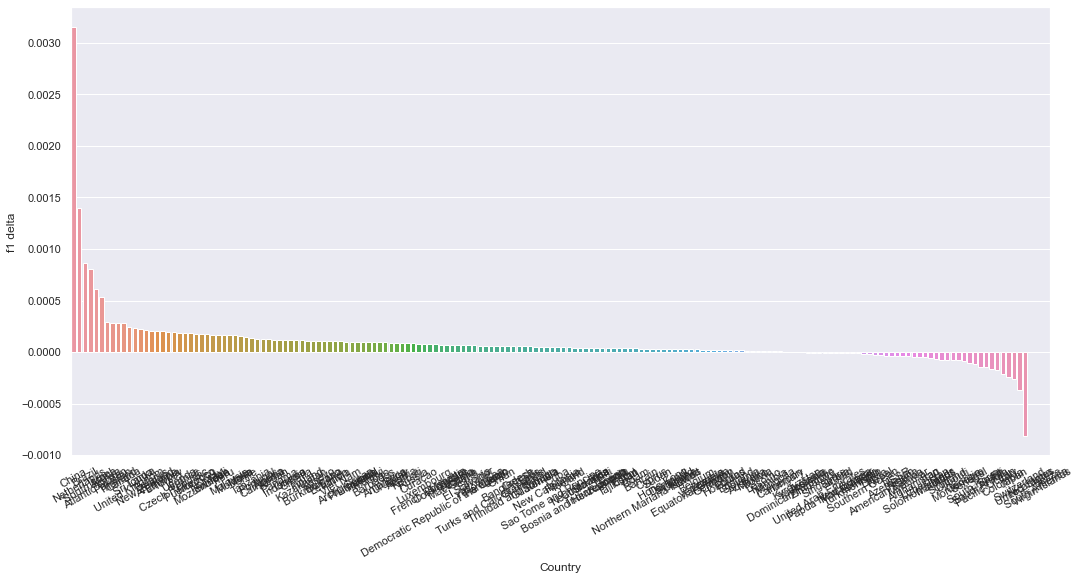

In [12]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
ax = sns.barplot(x='Country', y='f1 delta', data=iclogo.sort_values(by='f1 delta', ascending=False))
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

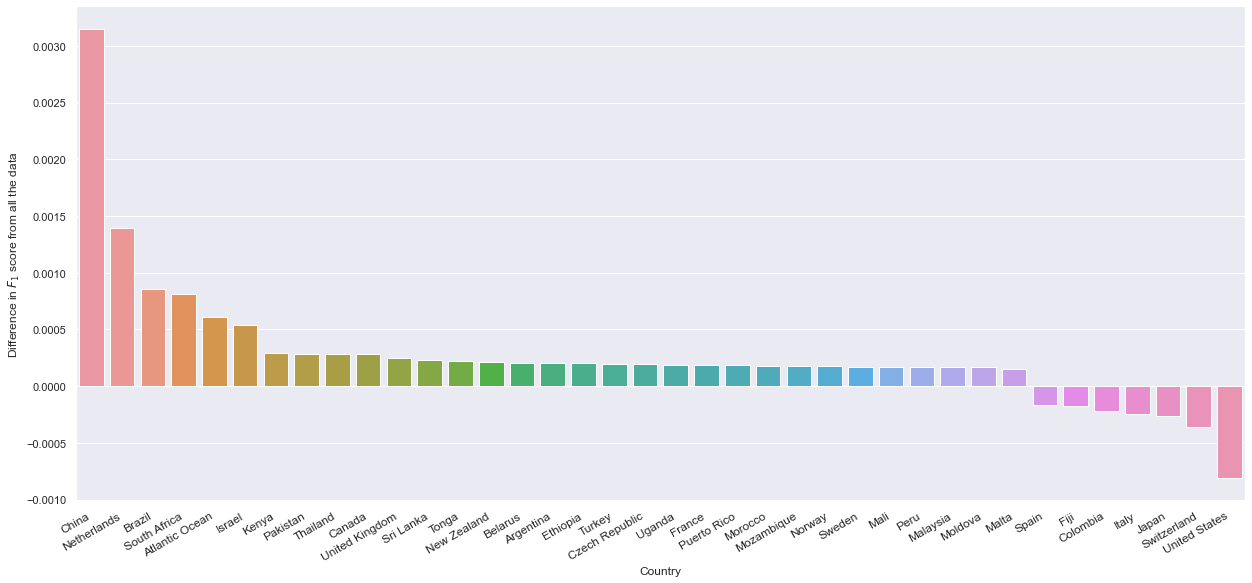

In [13]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
iclogotop = iclogo[iclogo['f1 delta'].abs() > 0.00015].sort_values(by='f1 delta', ascending=False)
ax = sns.barplot(x='Country', y='f1 delta', data=iclogotop)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=12)
ax.set_ylabel("Difference in $F_1$ score from all the data")
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/country_importance.png')
fig.savefig('images/country_importance.svg')

In [14]:
iclogotop

,Code,Country,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
127,41,China,0.003151,4.884953,4.0,16135.0,4.406656,3303.0,0.0,74.0,2.0,19.418620
36,137,Netherlands,0.001397,4.588448,3.0,1271.0,4.410578,277.0,0.0,22.0,1.0,19.453199
118,31,Brazil,0.000860,4.868421,4.0,3515.0,3.954404,722.0,0.0,38.0,4.0,15.637309
72,186,South Africa,0.000809,5.566108,5.0,5978.0,4.787352,1074.0,0.0,41.0,6.0,22.918738
28,13,Atlantic Ocean,0.000612,1.510345,0.0,876.0,2.728642,580.0,0.0,22.0,0.0,7.445489
173,96,Israel,0.000535,3.131868,1.0,570.0,4.190779,182.0,0.0,22.0,0.0,17.562625
4,102,Kenya,0.000295,6.380952,6.0,268.0,5.041063,42.0,0.0,23.0,1.0,25.412311
48,151,Pakistan,0.000284,5.686508,5.0,1433.0,3.391009,252.0,0.0,25.0,3.0,11.498941
87,207,Thailand,0.000283,6.341772,5.0,3006.0,5.903851,474.0,0.0,74.0,4.0,34.855461
123,36,Canada,0.000283,5.172551,2.0,9083.0,6.043183,1756.0,0.0,35.0,0.0,36.520067


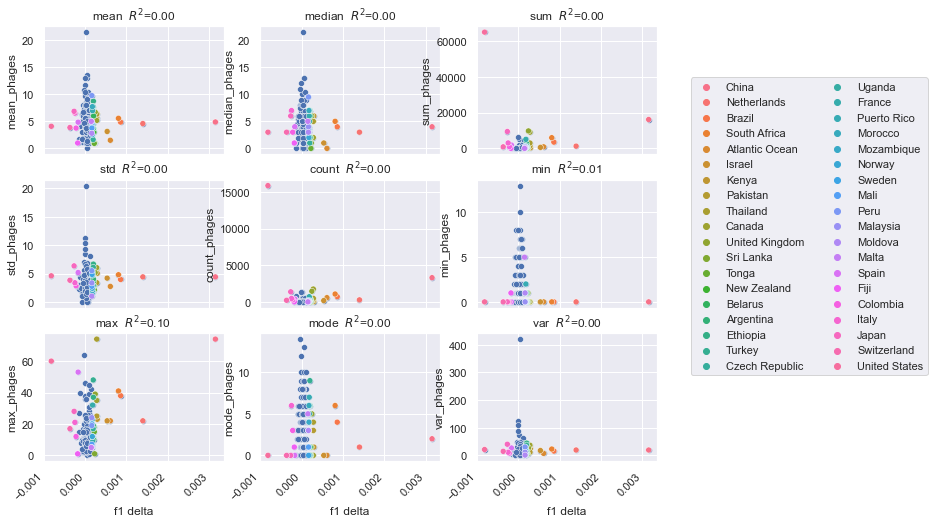

In [15]:
cols = [
        ['mean_phages', 'median_phages', 'sum_phages'],
        ['std_phages', 'count_phages', 'min_phages'], 
        ['max_phages', 'mode_phages', 'var_phages']
]

model = LinearRegression()

datalen = len(iclogo['f1 delta'])
x = iclogo['f1 delta'].fillna(0).values.reshape(datalen, 1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(11, 8), sharex=True)

for i in 0,1,2:
    for j in 0,1,2:
        y = iclogo[cols[i][j]].fillna(0).values.reshape(datalen, 1)
        m = model.fit(x, y)        
        bx = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iclogo, ax=ax[i][j])
        bx2 =  sns.scatterplot(x='f1 delta', y=cols[i][j], data=iclogotop, ax=ax[i][j], hue='Country')
        bx2.get_legend().remove()
        bx.set_title(f"{cols[i][j].replace('_phages', ' ')} $R^2$={m.score(x,y):.2f}")

l = plt.legend(bbox_to_anchor=(0,0,2.5,3), borderaxespad=0., ncol=2)
for i in 0, 1, 2:
    l = plt.setp(ax[2][i].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.savefig('images/country_importance_why.png')
fig.savefig('images/country_importance_why.svg')

# Category Importance

In [16]:
catgo = pd.read_csv('../data/Category_importance.tsv', delimiter="\t")
catgo = catgo[catgo['Category'].notnull()]

In [17]:
icc = pd.DataFrame(pd.unique(phagemeta['Category'])).set_index(0)
icc['mean_phages'] = phagemeta.groupby('Category').mean()['Kept']
icc['median_phages'] = phagemeta.groupby('Category').median()['Kept']
icc['sum_phages'] = phagemeta.groupby('Category').sum()['Kept']
icc['std_phages'] = phagemeta.groupby('Category').std()['Kept']
icc['count_phages'] = phagemeta.groupby('Category').count()['Kept']

icc['min_phages'] = phagemeta.groupby('Category').agg(['min'])['Kept']
icc['max_phages'] = phagemeta.groupby('Category').agg(['max'])['Kept']

icc['mode_phages'] = phagemeta.groupby('Category').agg(lambda x: mode(x)[0])['Kept']
icc['var_phages'] = phagemeta.groupby('Category').var()['Kept']

icc = icc.reset_index().rename({0:'Category'}, axis=1)
icc = icc[icc['Category'].notnull()]

iccatgo = pd.merge(catgo, icc, left_on='Category', right_on='Category', how='inner')
iccatgo

,Code,Category,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
0,0,air,6.432547e-05,2.200000,2.0,11.0,1.483240,5.0,0.0,4.0,2.0,2.200000
1,1,animal,7.374868e-04,4.594340,3.0,6331.0,4.075382,1378.0,0.0,29.0,0.0,16.608741
2,10,food,0.000000e+00,5.500688,5.0,3999.0,3.996856,727.0,0.0,24.0,2.0,15.974862
3,11,fresh water,9.350159e-05,3.044177,1.0,2274.0,4.475962,747.0,0.0,24.0,0.0,20.034239
4,13,hot spring,6.720941e-04,0.774775,0.0,344.0,1.471687,444.0,0.0,15.0,0.0,2.165863
5,14,human blood,6.971278e-04,4.596244,5.0,979.0,2.789195,213.0,0.0,21.0,5.0,7.779608
6,16,human brain,2.183420e-05,6.253846,3.0,813.0,6.510947,130.0,0.0,32.0,3.0,42.392427
7,17,human ear,3.819634e-06,2.350000,1.5,47.0,2.433862,20.0,0.0,9.0,1.0,5.923684
8,18,human eye,1.190415e-05,5.600000,5.0,112.0,3.830625,20.0,1.0,11.0,2.0,14.673684
9,19,human gut,7.520987e-06,7.457491,6.0,25087.0,5.087195,3364.0,0.0,37.0,6.0,25.879548


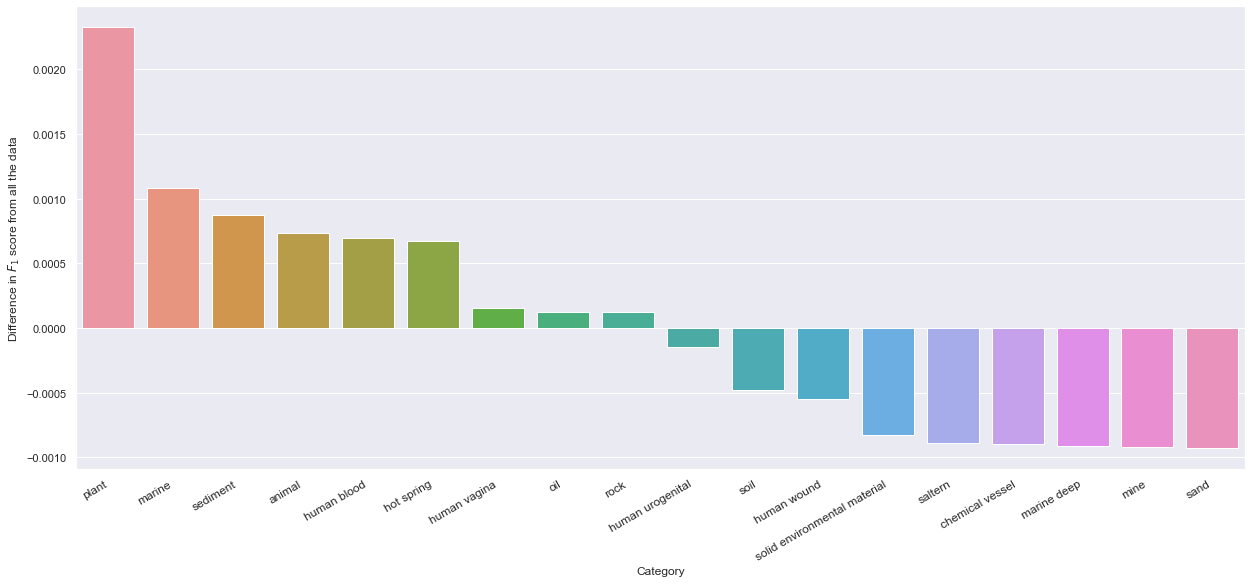

In [23]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
iccatgotop = iccatgo[iccatgo['f1 delta'].abs() > 0.0001].sort_values(by='f1 delta', ascending=False)
ax = sns.barplot(x='Category', y='f1 delta', data=iccatgotop)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=12)
ax.set_ylabel("Difference in $F_1$ score from all the data")
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('images/category_importance.png')
fig.savefig('images/category_importance.svg')

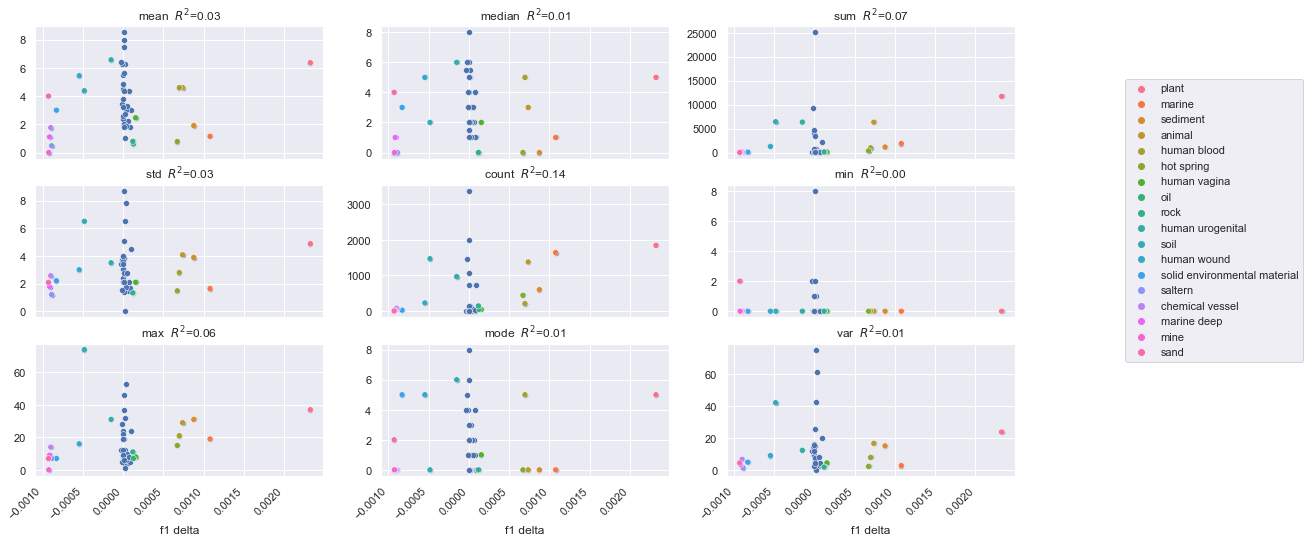

In [22]:
cols = [
        ['mean_phages', 'median_phages', 'sum_phages'],
        ['std_phages', 'count_phages', 'min_phages'], 
        ['max_phages', 'mode_phages', 'var_phages']
]

model = LinearRegression()

datalen = len(iccatgo['f1 delta'])
x = iccatgo['f1 delta'].fillna(0).values.reshape(datalen, 1)

#fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharex=True)
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True)

for i in 0,1,2:
    for j in 0,1,2:
        y = iccatgo[cols[i][j]].fillna(0).values.reshape(datalen, 1)
        m = model.fit(x, y)        
        bx = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iccatgo, ax=ax[i][j])
        bx2 = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iccatgotop, ax=ax[i][j], hue='Category')
        bx2.get_legend().remove()
        bx.set_ylabel("")
        bx2.set_ylabel("")
        bx.set_title(f"{cols[i][j].replace('_phages', ' ')} $R^2$={m.score(x,y):.2f}")


l = plt.legend(bbox_to_anchor=(0,0,2,3), borderaxespad=0., ncol=1)
for i in 0, 1, 2:
    l = plt.setp(ax[2][i].get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.tight_layout() this gives an error : Tight layot not applied
fig.savefig('images/category_importance_why.png', bbox_inches = "tight")
fig.savefig('images/category_importance_why.svg')